In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive/')

# ▶ 경로 설정 (※강의자료가 위치에 있는 경로 확인)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')   # 파일명 제외! 경로 위치만!!
os.getcwd()

# df = pd.read_csv('C:/Users/lovl5/Desktop/vscode/최종프로젝트/vestiaire.csv')
# df.to_parquet("vestiaire.parquet", engine="pyarrow", compression="snappy")

# 원본 데이터 : df
df = pd.read_parquet('merge_df.parquet', engine="pyarrow")

Mounted at /content/drive/


In [ ]:
df.columns

Index(['상품ID', '상품유형', '상품명', '상품설명', '상품키워드', '상품성별대상', '상품카테고리', '상품하위카테고리',
       '상품시즌', '상품상태', '상품좋아요수', '상품재질', '상품색상', '브랜드ID', '판매자ID', '판매자뱃지',
       '판매자뱃지등급', '판매자이름', '평균배송시간', '판매자국가', '판매상품수', '등록상품수', '판매자커뮤니티순위',
       '판매자팔로워수', '정품인증통과율', '군집', '브랜드명', '브랜드URL', '판매여부', '예약여부', '구매가능여부',
       '창고명', '제품정가(usd)', '판매가', '판매자수익', '판매자수수료', '할인액', '국제배송비포함여부',
       '구매자수수료', '회사수익'],
      dtype='object')

In [ ]:
# 13,727건의 상품 판매
sold_true = df[df['판매여부']==True]

- 현재 홈페이지 기준 =>
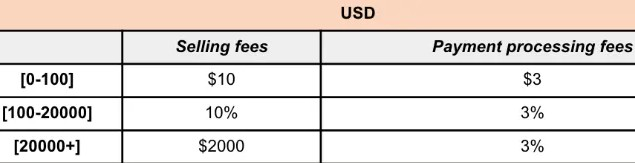

## 기존 판매자 뱃지
- 각 거래마다 할인 받은 프로모션이나 쿠폰 등의 종류를 파악하기 어려움
- -> 따라서 가상의 금액 데이터 필요

In [ ]:
sold_true_1 = sold_true.copy()

In [ ]:
# 제품정가(usd) : 원래 상품가격
# 판매가 : 판매자가 제시한 가격
#
# 현재 기준
# 판매자 수수료 = 판매가의 10% (100달러 미만 10달러, 20000달러 이상 2000달러)
# 구매자 수수료 = 판매가의 3% (100달러 미만 3달러)
#
# 따라서 Expert seller나 Trusted seller에게 판매자수수료 할인 혜택을 부여함
# 100이상인 경우 Expert seller의 4,124 거래건에 2%, Trusted seller의 2,882 거래건에 1.5% 혜택을 주었다고 가정하면

In [ ]:
def seller_fee(sell_price, seller_badge, pass_rate) :
    if sell_price < 100:
        return 10
    elif sell_price < 20000:
        if seller_badge == "Expert":
            return sell_price * 0.08
        elif seller_badge == "Trusted":
            return sell_price * 0.085
        return sell_price * 0.1
    else:
        return 2000

sold_true_1['판매자수수료'] = sold_true_1.apply(lambda row: seller_fee(row['판매가'], row['판매자뱃지'], row['정품인증통과율']), axis=1)

def buyers_fees(sell_price):
    if sell_price < 100:
        return 3
    else:
        return sell_price * 0.03

sold_true_1['구매자수수료'] = sold_true_1['판매가'].apply(buyers_fees)

sold_true_1['판매자수익'] = sold_true_1['판매가'] - sold_true_1['판매자수수료']
sold_true_1['회사수익'] = sold_true_1['판매자수수료'] + sold_true_1['구매자수수료']

sold_true_1[['판매자뱃지', '제품정가(usd)',	'판매가',	'판매자수익',	'판매자수수료', '구매자수수료',	'회사수익', '정품인증통과율']]

,판매자뱃지,제품정가(usd),판매가,판매자수익,판매자수수료,구매자수수료,회사수익,정품인증통과율
0,Common,272.92,223.65,201.28500,22.36500,6.7095,29.07450,0.0
9,Trusted,437.97,358.91,328.40265,30.50735,10.7673,41.27465,95.0
12,Common,444.74,370.62,333.55800,37.06200,11.1186,48.18060,100.0
19,Common,145.75,119.44,107.49600,11.94400,3.5832,15.52720,81.0
53,Common,55.37,46.14,36.14000,10.00000,3.0000,13.00000,85.0
...,...,...,...,...,...,...,...,...
899808,Expert,29.16,24.30,14.30000,10.00000,3.0000,13.00000,96.0
899821,Common,332.28,276.90,249.21000,27.69000,8.3070,35.99700,0.0
899920,Common,447.90,373.25,335.92500,37.32500,11.1975,48.52250,81.0
899954,Common,51.12,42.60,32.60000,10.00000,3.0000,13.00000,93.0


In [ ]:
# 총 363935.4949 usd
badge_profit = sold_true_1['회사수익'].sum()

badge_profit

np.float64(363935.49490000005)

## 새 군집

In [ ]:
sold_true_2 = sold_true.copy()

In [ ]:
sold_true_2[['군집', '제품정가(usd)', '판매가', '판매자수익', '판매자수수료', '구매자수수료', '회사수익']]

,군집,제품정가(usd),판매가,판매자수익,판매자수수료,구매자수수료,회사수익
0,4.0,272.92,223.65,201.2850,22.3650,6.7095,29.0745
9,1.0,437.97,358.91,330.1972,28.7128,10.7673,39.4801
12,0.0,444.74,370.62,333.5580,37.0620,11.1186,48.1806
19,3.0,145.75,119.44,107.4960,11.9440,3.5832,15.5272
53,1.0,55.37,46.14,36.1400,10.0000,3.0000,13.0000
...,...,...,...,...,...,...,...
899808,1.0,29.16,24.30,14.3000,10.0000,3.0000,13.0000
899821,4.0,332.28,276.90,249.2100,27.6900,8.3070,35.9970
899920,3.0,447.90,373.25,335.9250,37.3250,11.1975,48.5225
899954,1.0,51.12,42.60,32.6000,10.0000,3.0000,13.0000


In [ ]:
# 제품정가(usd) : 원래 상품가격
# 판매가 : 판매자가 제시한 가격
#
# 현재 기준
# 판매자 수수료 = 판매가의 10% (100달러 미만 10달러, 20000달러 이상 2000달러)
# 구매자 수수료 = 판매가의 3% (100달러 미만 3달러)
#
# 우수 판매자 기준
# 군집 == 1, 정품인증통과율 90이상

In [ ]:
def seller_fee(sell_price, seller_cluster, seller_pass_rate):
    if sell_price < 100:
        return 10
    elif sell_price < 20000:
        if seller_cluster == 1 and seller_pass_rate >=90 :
            return sell_price * (0.1 - 0.025)
        return sell_price * 0.1
    else:
        return 2000

sold_true_2['판매자수수료'] = sold_true_2.apply(lambda row: seller_fee(row['판매가'], row['군집'], row['정품인증통과율']), axis=1)

def buyers_fees(sell_price):
    if sell_price < 100:
        return 3
    else:
        return sell_price * 0.03

sold_true_2['구매자수수료'] = sold_true_2['판매가'].apply(buyers_fees)

sold_true_2['판매자수익'] = sold_true_2['판매가'] - sold_true_2['판매자수수료']
sold_true_2['회사수익'] = sold_true_2['판매자수수료'] + sold_true_2['구매자수수료']

sold_true_2[['군집', '제품정가(usd)',	'판매가',	'판매자수익',	'판매자수수료', '구매자수수료',	'회사수익']]

,군집,제품정가(usd),판매가,판매자수익,판매자수수료,구매자수수료,회사수익
0,4.0,272.92,223.65,201.28500,22.36500,6.7095,29.07450
9,1.0,437.97,358.91,331.99175,26.91825,10.7673,37.68555
12,0.0,444.74,370.62,333.55800,37.06200,11.1186,48.18060
19,3.0,145.75,119.44,107.49600,11.94400,3.5832,15.52720
53,1.0,55.37,46.14,36.14000,10.00000,3.0000,13.00000
...,...,...,...,...,...,...,...
899808,1.0,29.16,24.30,14.30000,10.00000,3.0000,13.00000
899821,4.0,332.28,276.90,249.21000,27.69000,8.3070,35.99700
899920,3.0,447.90,373.25,335.92500,37.32500,11.1975,48.52250
899954,1.0,51.12,42.60,32.60000,10.00000,3.0000,13.00000


In [ ]:
# 2%
print(sold_true_2['회사수익'].sum())

print(sold_true_2['회사수익'].sum() - badge_profit)

print((sold_true_2['회사수익'].sum() - badge_profit)*100/ badge_profit)

371243.3229
7307.8279999999795
2.008000896424785


In [ ]:
# 2.25%
print(sold_true_2['회사수익'].sum())

print(sold_true_2['회사수익'].sum() - badge_profit)

print((sold_true_2['회사수익'].sum() - badge_profit)*100/ badge_profit)

369418.8642
5483.369299999962
1.5066871401226332


In [ ]:
# 2.5%
print(sold_true_2['회사수익'].sum())

print(sold_true_2['회사수익'].sum() - badge_profit)

print((sold_true_2['회사수익'].sum() - badge_profit)*100/ badge_profit)

367594.4055
3658.9105999999447
1.005373383820481
